# INF-0616 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br Hudson Bruno -- hudson.bruno@ic.unicamp.br

Este notebook faz parte da disciplina INF-0616 no curso de extensão MDC.
Demais artefatos podem ser encontrados no moodle da disciplina: moodle.lab.ic.unicamp.br/456

Instituto de Computação - Unicamp 2021

In [90]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.fixes import loguniform

import seaborn as sns

from IPython.display import display

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas a um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [2]:
train = pd.read_csv('./doctor-fees-train.csv')
train, test = train_test_split(train, test_size=.3, random_state=7128)

#### Pré-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [3]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

C:\Users\romeu\AppData\Local\Temp/ipykernel_1984/1485874194.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
C:\Users\romeu\AppData\Local\Temp/ipykernel_1984/1485874194.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()


- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [4]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [5]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [6]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

c:\users\romeu\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\romeu\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


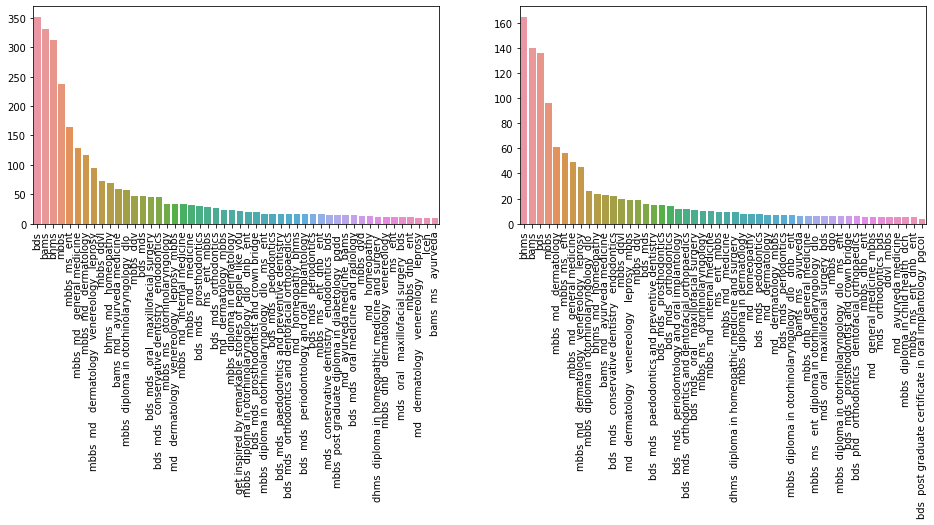

In [7]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

c:\users\romeu\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\romeu\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


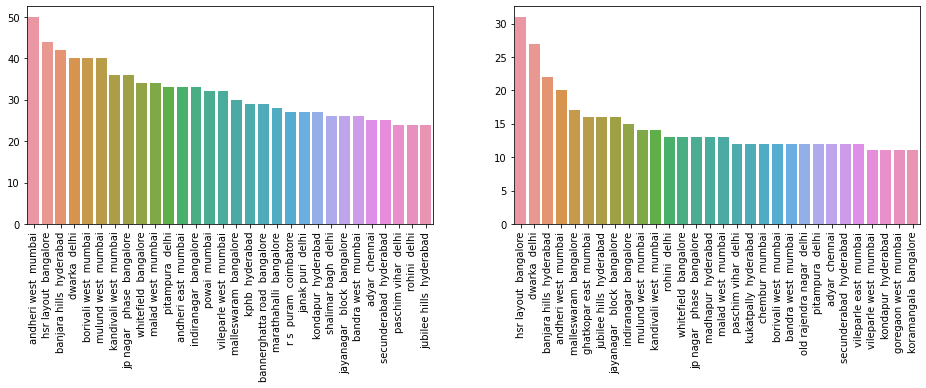

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

c:\users\romeu\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\romeu\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


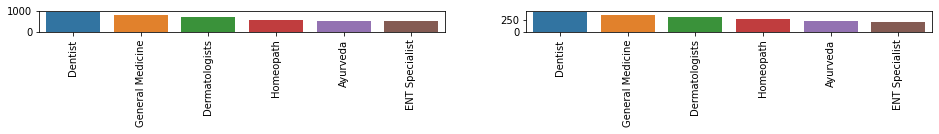

In [9]:
plt.figure(figsize=(16, +.4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [11]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Substituímos as células desconhecidas pelo valor mediano e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [12]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [13]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
# Apesar da normalização ser imprescindível, ela está acontecendo no conjunto de teste com os parâmetros 
# que encontramos no cnjunto de treino. Logo, não estamos usando informação do teste, mas apenas adequando a
# faixa de valores para a faixa com a qual o modelo foi treinado.
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

In [14]:
pd.DataFrame.sparse.from_spmatrix(train_e)

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.018123,0.196602
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.749289,0.196602
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.032398,0.196602
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.659678,0.756092
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.555791,0.196602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.057213,0.196602
4167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.146824,-0.362888
4168,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.387108,0.196602
4169,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.107734,0.196602


In [15]:
len(ye_train)

4171

# obs: não entendi pq transformar as saídas

**Atividade (3 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaramm a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSerach, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time

In [17]:
kernel = ["linear","poly","rbf","sigmoid"]
gamma = [0.0001, 0.01, 0.1, 1, 10, 100]
C = [0.0001, 0.01, 1, 10, 100]
epsilon = [0.1,0.2,0.6,1,2,4]
parameters = [{'kernel': kernel ,
               #'gamma': gamma,
               'C': C,
               'epsilon': epsilon}]

cv_folds = 5


In [18]:
start_time = time.time()
svr = GridSearchCV(SVR(), parameters, cv = cv_folds, scoring  = "neg_mean_absolute_error" , verbose=3)
svr.fit(train_e, ye_train)
end_time = time.time()
print("total time {:.2f} seconds".format( end_time - start_time))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.789 total time=   1.0s
[CV 2/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.796 total time=   1.1s
[CV 3/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.819 total time=   1.0s
[CV 4/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.823 total time=   1.0s
[CV 5/5] END C=0.0001, epsilon=0.1, kernel=linear;, score=-0.804 total time=   1.0s
[CV 1/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.797 total time=   1.1s
[CV 2/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.807 total time=   1.1s
[CV 3/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.824 total time=   1.1s
[CV 4/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.828 total time=   1.1s
[CV 5/5] END C=0.0001, epsilon=0.1, kernel=poly;, score=-0.811 total time=   1.0s
[CV 1/5] END C=0.0001, epsilon=0.1, kernel=rbf;, score=-0.797 total time=   1.1s
[CV 2/5] END C=0.0001, eps

[CV 2/5] END C=0.0001, epsilon=4, kernel=sigmoid;, score=-1.138 total time=   0.0s
[CV 3/5] END C=0.0001, epsilon=4, kernel=sigmoid;, score=-1.161 total time=   0.0s
[CV 4/5] END C=0.0001, epsilon=4, kernel=sigmoid;, score=-1.154 total time=   0.0s
[CV 5/5] END C=0.0001, epsilon=4, kernel=sigmoid;, score=-1.091 total time=   0.0s
[CV 1/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.723 total time=   1.0s
[CV 2/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.717 total time=   1.0s
[CV 3/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.756 total time=   1.1s
[CV 4/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.749 total time=   0.9s
[CV 5/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.736 total time=   0.6s
[CV 1/5] END .C=0.01, epsilon=0.1, kernel=poly;, score=-0.749 total time=   0.6s
[CV 2/5] END .C=0.01, epsilon=0.1, kernel=poly;, score=-0.761 total time=   1.4s
[CV 3/5] END .C=0.01, epsilon=0.1, kernel=poly;, score=-0.790 total time=   1.4s
[CV 4/5] END .C

[CV 3/5] END .C=0.01, epsilon=4, kernel=linear;, score=-1.161 total time=   0.0s
[CV 4/5] END .C=0.01, epsilon=4, kernel=linear;, score=-1.154 total time=   0.0s
[CV 5/5] END .C=0.01, epsilon=4, kernel=linear;, score=-1.091 total time=   0.0s
[CV 1/5] END ...C=0.01, epsilon=4, kernel=poly;, score=-1.207 total time=   0.0s
[CV 2/5] END ...C=0.01, epsilon=4, kernel=poly;, score=-1.138 total time=   0.0s
[CV 3/5] END ...C=0.01, epsilon=4, kernel=poly;, score=-1.161 total time=   0.0s
[CV 4/5] END ...C=0.01, epsilon=4, kernel=poly;, score=-1.154 total time=   0.0s
[CV 5/5] END ...C=0.01, epsilon=4, kernel=poly;, score=-1.091 total time=   0.0s
[CV 1/5] END ....C=0.01, epsilon=4, kernel=rbf;, score=-1.207 total time=   0.0s
[CV 2/5] END ....C=0.01, epsilon=4, kernel=rbf;, score=-1.138 total time=   0.0s
[CV 3/5] END ....C=0.01, epsilon=4, kernel=rbf;, score=-1.161 total time=   0.0s
[CV 4/5] END ....C=0.01, epsilon=4, kernel=rbf;, score=-1.154 total time=   0.0s
[CV 5/5] END ....C=0.01, eps

[CV 2/5] END ......C=1, epsilon=2, kernel=poly;, score=-1.039 total time=   0.0s
[CV 3/5] END ......C=1, epsilon=2, kernel=poly;, score=-1.060 total time=   0.0s
[CV 4/5] END ......C=1, epsilon=2, kernel=poly;, score=-1.059 total time=   0.0s
[CV 5/5] END ......C=1, epsilon=2, kernel=poly;, score=-1.041 total time=   0.0s
[CV 1/5] END .......C=1, epsilon=2, kernel=rbf;, score=-1.123 total time=   0.0s
[CV 2/5] END .......C=1, epsilon=2, kernel=rbf;, score=-1.055 total time=   0.0s
[CV 3/5] END .......C=1, epsilon=2, kernel=rbf;, score=-1.074 total time=   0.0s
[CV 4/5] END .......C=1, epsilon=2, kernel=rbf;, score=-1.065 total time=   0.0s
[CV 5/5] END .......C=1, epsilon=2, kernel=rbf;, score=-1.055 total time=   0.0s
[CV 1/5] END ..C=1, epsilon=2, kernel=sigmoid;, score=-20.554 total time=   1.2s
[CV 2/5] END ..C=1, epsilon=2, kernel=sigmoid;, score=-18.459 total time=   1.2s
[CV 3/5] END ..C=1, epsilon=2, kernel=sigmoid;, score=-18.251 total time=   1.4s
[CV 4/5] END ..C=1, epsilon=

[CV 3/5] END .....C=10, epsilon=1, kernel=poly;, score=-0.812 total time=   2.5s
[CV 4/5] END .....C=10, epsilon=1, kernel=poly;, score=-0.831 total time=   6.8s
[CV 5/5] END .....C=10, epsilon=1, kernel=poly;, score=-0.788 total time=   2.8s
[CV 1/5] END ......C=10, epsilon=1, kernel=rbf;, score=-0.816 total time=   0.6s
[CV 2/5] END ......C=10, epsilon=1, kernel=rbf;, score=-0.773 total time=   0.5s
[CV 3/5] END ......C=10, epsilon=1, kernel=rbf;, score=-0.795 total time=   0.5s
[CV 4/5] END ......C=10, epsilon=1, kernel=rbf;, score=-0.810 total time=   0.5s
[CV 5/5] END ......C=10, epsilon=1, kernel=rbf;, score=-0.772 total time=   0.5s
[CV 1/5] END C=10, epsilon=1, kernel=sigmoid;, score=-208.714 total time=   1.4s
[CV 2/5] END C=10, epsilon=1, kernel=sigmoid;, score=-185.068 total time=   1.4s
[CV 3/5] END C=10, epsilon=1, kernel=sigmoid;, score=-183.095 total time=   1.4s
[CV 4/5] END C=10, epsilon=1, kernel=sigmoid;, score=-176.684 total time=   1.4s
[CV 5/5] END C=10, epsilon=1

[CV 4/5] END ..C=100, epsilon=0.6, kernel=poly;, score=-0.889 total time= 1.9min
[CV 5/5] END ..C=100, epsilon=0.6, kernel=poly;, score=-0.831 total time=  50.9s
[CV 1/5] END ...C=100, epsilon=0.6, kernel=rbf;, score=-0.809 total time=   2.1s
[CV 2/5] END ...C=100, epsilon=0.6, kernel=rbf;, score=-0.756 total time=   2.2s
[CV 3/5] END ...C=100, epsilon=0.6, kernel=rbf;, score=-0.787 total time=   2.3s
[CV 4/5] END ...C=100, epsilon=0.6, kernel=rbf;, score=-0.810 total time=   2.2s
[CV 5/5] END ...C=100, epsilon=0.6, kernel=rbf;, score=-0.773 total time=   2.3s
[CV 1/5] END C=100, epsilon=0.6, kernel=sigmoid;, score=-2086.660 total time=   1.4s
[CV 2/5] END C=100, epsilon=0.6, kernel=sigmoid;, score=-1850.124 total time=   0.9s
[CV 3/5] END C=100, epsilon=0.6, kernel=sigmoid;, score=-1830.427 total time=   0.6s
[CV 4/5] END C=100, epsilon=0.6, kernel=sigmoid;, score=-1766.560 total time=   1.4s
[CV 5/5] END C=100, epsilon=0.6, kernel=sigmoid;, score=-1819.477 total time=   1.4s
[CV 1/5]

In [19]:
means = -1*svr.cv_results_['mean_test_score']
params = svr.cv_results_['params']
df_results = pd.concat([pd.DataFrame({'mean_test_score':means}), pd.DataFrame(params)], axis = 1)

In [20]:
def plot_vars(df = df_results, var_a = 'epsilon', var_b = 'C', figsize_i = (12,12)):

    fig, axs = plt.subplots(2, 2, figsize = figsize_i)

    fig.suptitle('Analise de {} vs {}'.format(var_a,var_b))
    
    df_data_l = df_results[df_results['kernel'] == 'linear'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    df_data_p = df_results[df_results['kernel'] == 'poly'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    df_data_r = df_results[df_results['kernel'] == 'rbf'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    df_data_s = df_results[df_results['kernel'] == 'sigmoid'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    

    sns.heatmap(ax = axs[0, 0], data = df_data_l, annot = True)
    axs[0, 0].set_title('Kernel - linear')

    sns.heatmap(ax = axs[0, 1], data =df_data_p, annot = True)
    axs[0, 1].set_title('Kernel - poly')

    sns.heatmap(ax = axs[1, 0], data =df_data_r, annot = True)
    axs[1, 0].set_title('Kernel - rbf')

    sns.heatmap(ax = axs[1, 1],data =df_data_s, annot = True)
    axs[1, 1].set_title('Kernel -sigmoid')

    plt.tight_layout()


# pra não ter que ficar rodando só analisar os resultados do df
``` python
df_results.to_excel('./df_results.xlsx',index = False)
```

NameError: name 'AAAA' is not defined

#### deixei na forma de função para caso forem adicionar Gamma no Grid search fica mais fácil pra analisar

In [22]:
ye_test.min()

-1.5851043213885965

In [23]:
ye_test.max()

3.105409219166307

# 01 - Heatmaps

In [24]:
df_results[df_results['kernel'] == 'sigmoid']

,mean_test_score,C,epsilon,kernel
3,0.812262,0.0001,0.1,sigmoid
7,0.815074,0.0001,0.2,sigmoid
11,0.812153,0.0001,0.6,sigmoid
15,0.822160,0.0001,1.0,sigmoid
19,1.040862,0.0001,2.0,sigmoid
23,1.150492,0.0001,4.0,sigmoid
27,0.766698,0.0100,0.1,sigmoid
31,0.767771,0.0100,0.2,sigmoid
35,0.772304,0.0100,0.6,sigmoid
39,0.809083,0.0100,1.0,sigmoid


#### 01.01 - Epsilon vs C

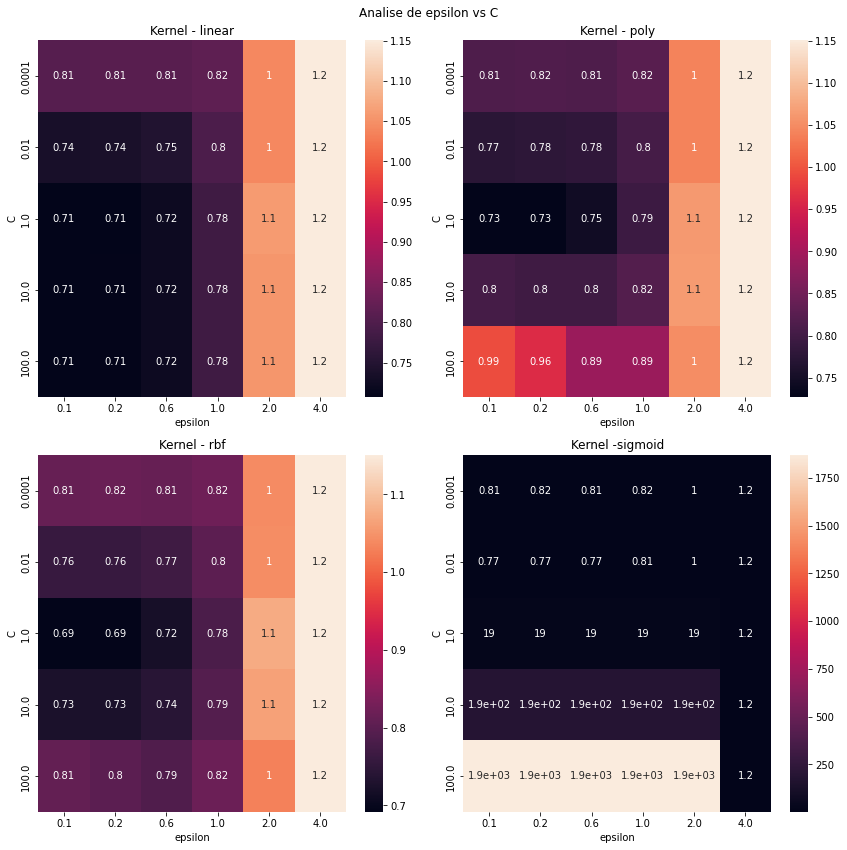

In [25]:
plot_vars(var_a = 'epsilon', var_b = 'C')

#### 01.02 - Epsilon vs C

In [26]:
pd.qcut(df_results['mean_test_score'], q = 10).value_counts().sort_index()

(0.691, 0.725]        12
(0.725, 0.768]        12
(0.768, 0.794]        12
(0.794, 0.809]        12
(0.809, 0.818]        12
(0.818, 1.041]        12
(1.041, 1.067]        12
(1.067, 1.15]         21
(1.15, 18.712]         3
(18.712, 1870.658]    12
Name: mean_test_score, dtype: int64

#### 10% melhores classificadores

In [27]:
df_results[df_results['mean_test_score'] <= 0.725]

,mean_test_score,C,epsilon,kernel
48,0.707067,1.0,0.1,linear
50,0.691855,1.0,0.1,rbf
52,0.707200,1.0,0.2,linear
54,0.694784,1.0,0.2,rbf
56,0.722091,1.0,0.6,linear
58,0.719491,1.0,0.6,rbf
72,0.707942,10.0,0.1,linear
76,0.708894,10.0,0.2,linear
80,0.722261,10.0,0.6,linear
96,0.707993,100.0,0.1,linear


In [28]:
np.random.seed(1082141)
sns.set()

**Atividade (2 pts):** Treine 2 outros regressores a sua escolha (Regressão linear, polinomial, árvore de regeressão, etc.) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discuntindo os resultados.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [79]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],

      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



In [4]:
pd.DataFrame(y_test).value_counts().sort_index()

0    93
1    91
2    88
3    89
4    98
5    96
6    88
7    86
8    85
9    85
dtype: int64

In [5]:
pd.DataFrame(x_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,898.0,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,...,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000
mean,0.0,0.312918,5.388641,11.955457,11.863029,5.766147,1.386414,0.094655,0.003341,2.082405,...,3.772829,0.217149,0.001114,0.293987,5.789532,12.094655,11.641425,6.749443,2.033408,0.342984
std,0.0,0.957904,4.807019,4.274867,4.261015,5.696024,3.345393,0.795020,0.074585,3.174927,...,4.934991,1.017492,0.033370,0.988444,5.183717,4.403170,5.029516,5.961660,4.016826,1.795063
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,9.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,5.000000,13.000000,13.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,4.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,12.000000,2.000000,15.000000,...,16.000000,10.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


### 256 primeiras amostras no conjunto de treinamento

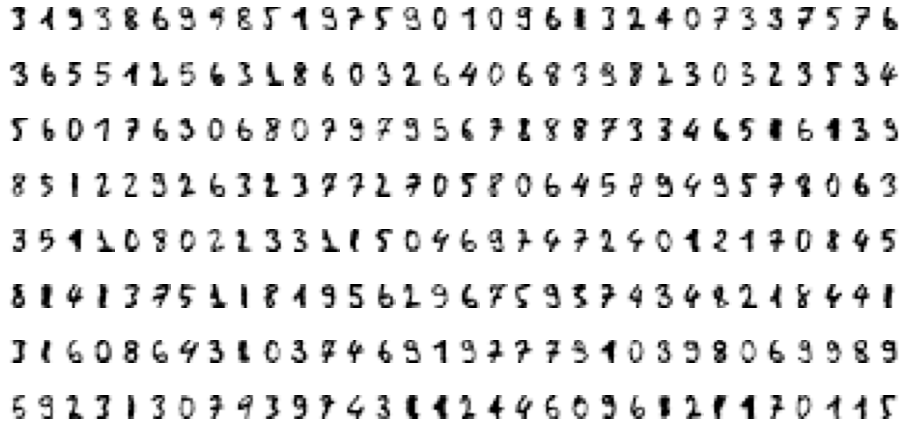

In [30]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error

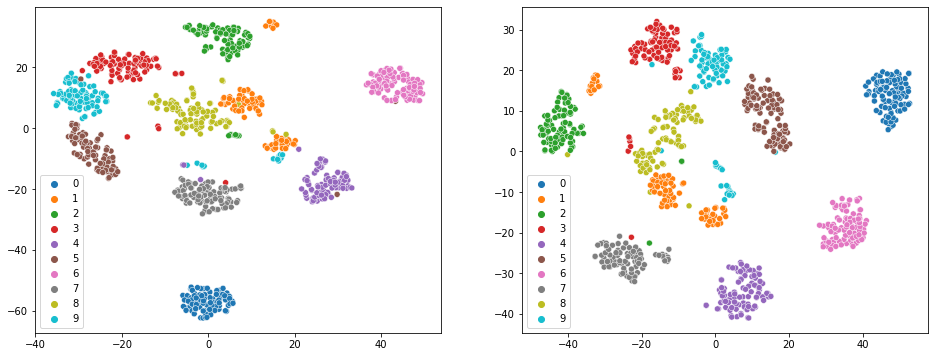

In [6]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

c:\users\romeu\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\romeu\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


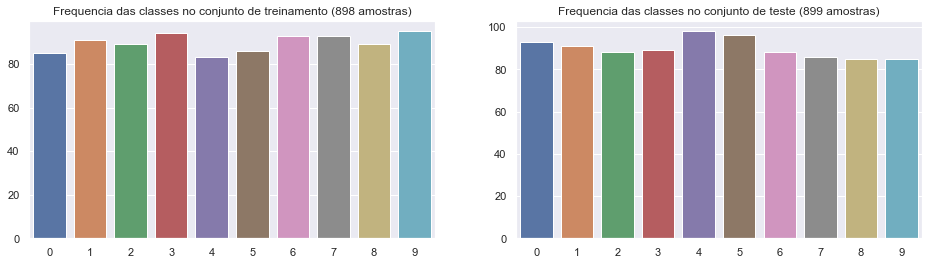

In [32]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

### Normalização

In [132]:
norm = StandardScaler()
norm.fit(x_train)
x_train_norm  = norm.transform(x_train)

norm.fit(x_test)
x_test_norm  = norm.transform(x_test)

### Modelo

In [84]:
kernel = ["linear"]
C = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
gamma = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

parameters = {'kernel': kernel, 'C': C}#, 'gamma': gamma}
svc = svm.SVC()
clf = GridSearchCV(estimator=svc, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1, verbose=1)
clf.fit(x_train_norm, y_train)
print(clf.best_params_)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
{'C': 0.1, 'kernel': 'linear'}


In [133]:
linear_svm = svm.SVC( C= 0.1,kernel="linear")
linear_svm.fit(x_train_norm, y_train)


### Conjunto treino

In [ ]:
linear_svm_predicts_train = linear_svm.predict(x_train_norm)

In [94]:
confusion_matrix(y_train, linear_svm_predicts_train)

array([[85,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 91,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 89,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 94,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 83,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 86,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 93,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 93,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0, 87,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 95]])

In [98]:
balanced_accuracy_score(y_train, linear_svm_predicts_train)

0.997752808988764

### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

In [135]:
linear_svm_predicts_test = linear_svm.predict(x_test_norm)

In [136]:
confusion_matrix(y_test, linear_svm_predicts_test)

array([[92,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 90,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 88,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 87,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0, 96,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0, 93,  0,  0,  1,  0],
       [ 2,  1,  0,  0,  0,  0, 84,  0,  1,  0],
       [ 0,  0,  0,  0,  2,  2,  0, 81,  0,  1],
       [ 0,  3,  1,  2,  0,  1,  0,  0, 78,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 83]])

In [104]:
balanced_accuracy_score(y_test, linear_svm_predicts_test)


0.9694651794181837

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

In [91]:
kernel = ["rbf"]
C = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
gamma = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

parameters = {'kernel': kernel, 'C': C, 'gamma': gamma}
svc = svm.SVC()
clf_rbf = GridSearchCV(estimator = svc, param_grid = parameters, scoring = 'accuracy', cv =10, n_jobs = -1, verbose = 3)
clf_rbf.fit(x_train_norm, y_train)
print(clf_rbf.best_params_)


Fitting 10 folds for each of 196 candidates, totalling 1960 fits
[CV 10/10] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.191 total time=   0.2s
[CV 4/10] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.100 total time=   0.2s
[CV 8/10] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.200 total time=   0.2s
[CV 9/10] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.180 total time=   0.2s
[CV 2/10] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.100 total time=   0.2s
[CV 4/10] END C=0.0001, gamma=0.001, kernel=rbf;, score=0.100 total time=   0.2s
[CV 7/10] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.200 total time=   0.2s
[CV 6/10] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.211 total time=   0.2s
[CV 2/10] END C=0.0001, gamma=0.001, kernel=rbf;, score=0.100 total time=   0.2s
[CV 5/10] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.100 total time=   0.2s
[CV 3/10] END C=0.0001, gamma=0.001, kernel=rbf;, score=0.100 total time=   0.2s
[CV 1/10] END C=0.0001, gamma=0.000

In [107]:
pd.set_option("display.max_columns", None)
pd.DataFrame()
means = clf_rbf.cv_results_['mean_test_score']
params = clf_rbf.cv_results_['params']
df_results = pd.concat([pd.DataFrame({'mean_test_score':means}), pd.DataFrame(params)], axis = 1)
df_results = df_results.sort_values('mean_test_score', ascending = False)


In [113]:
clf_rbf_grid = svm.SVC( C=5, kernel="rbf", gamma=0.01)
clf_rbf_grid.fit(x_train_norm, y_train)


### Conjunto Treino


In [ ]:
clf_rbf_grid_predict_train = clf_rbf_grid.predict(x_train_norm)

In [114]:
confusion_matrix(y_train, clf_rbf_grid_predict_train)


array([[85,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 91,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 89,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 94,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 83,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 86,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 93,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 93,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 89,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 95]])

In [115]:
balanced_accuracy_score(y_train, clf_rbf_grid_predict_train)

1.0

In [116]:
df_results[:10]


,mean_test_score,C,gamma,kernel
86,0.981099,5.0,0.0100,rbf
114,0.979988,20.0,0.0100,rbf
142,0.979988,100.0,0.0100,rbf
156,0.979988,200.0,0.0100,rbf
128,0.979988,50.0,0.0100,rbf
170,0.979988,500.0,0.0100,rbf
100,0.979988,10.0,0.0100,rbf
184,0.979988,1000.0,0.0100,rbf
72,0.979975,2.0,0.0100,rbf
168,0.978851,500.0,0.0001,rbf


### Conjunto Teste

In [117]:
clf_rbf_grid_predict_test = clf_rbf_grid.predict(x_test_norm)


In [120]:
confusion_matrix(y_test, clf_rbf_grid_predict_test)



array([[92,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 91,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 86,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 85,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 98,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 95,  0,  0,  0,  1],
       [ 1,  1,  0,  0,  0,  1, 85,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 85,  0,  1],
       [ 0,  2,  1,  0,  1,  0,  0,  1, 80,  0],
       [ 0,  0,  0,  1,  1,  0,  1,  0,  1, 81]])

In [122]:
balanced_accuracy_score(y_test, clf_rbf_grid_predict_test)


0.9759558383200468

**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

In [61]:
kernel = ["rbf"]
C = loguniform(1e-5, 1e4)
gamma = loguniform(1e-5, 1e4)

parameters = {'kernel': kernel, 'C': C, 'gamma': gamma}
svc = svm.SVC()
clf_rbf_02 = RandomizedSearchCV(estimator = svc, param_distributions = parameters, scoring = 'accuracy', cv =10, n_jobs = -1, verbose = 3)
clf_rbf_02.fit(x_train_norm, y_train)
print(clf_rbf_02.best_params_)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END C=908.7210387043142, gamma=1.2021668261390972, kernel=rbf;, score=0.100 total time=   0.1s
[CV 2/10] END C=908.7210387043142, gamma=1.2021668261390972, kernel=rbf;, score=0.111 total time=   0.1s
[CV 3/10] END C=908.7210387043142, gamma=1.2021668261390972, kernel=rbf;, score=0.100 total time=   0.2s
[CV 4/10] END C=908.7210387043142, gamma=1.2021668261390972, kernel=rbf;, score=0.111 total time=   0.2s
[CV 5/10] END C=908.7210387043142, gamma=1.2021668261390972, kernel=rbf;, score=0.133 total time=   0.2s
[CV 6/10] END C=908.7210387043142, gamma=1.2021668261390972, kernel=rbf;, score=0.133 total time=   0.2s
[CV 1/10] END C=2.5325933390912445e-05, gamma=0.1019171465916963, kernel=rbf;, score=0.100 total time=   0.2s
[CV 8/10] END C=908.7210387043142, gamma=1.2021668261390972, kernel=rbf;, score=0.111 total time=   0.2s
[CV 2/10] END C=2.5325933390912445e-05, gamma=0.1019171465916963, kernel=rbf;, score=0.100 t

In [123]:
clf_rbf_random = svm.SVC( kernel='rbf' ,C= 0.8787324890986387, gamma=  0.0015432644574156363)
clf_rbf_random.fit(x_train_norm, y_train)


### Conjunto Treino

In [ ]:
clf_rbf_random_predict_train = clf_rbf_random.predict(x_train_norm)

In [125]:
confusion_matrix(y_train, clf_rbf_random_predict_train)

array([[85,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 89,  1,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  2, 85,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  1, 87,  0,  1,  0,  2,  1,  2],
       [ 0,  3,  0,  0, 75,  0,  0,  1,  3,  1],
       [ 0,  0,  0,  0,  1, 79,  1,  0,  0,  5],
       [ 0,  0,  0,  0,  0,  0, 93,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 93,  0,  0],
       [ 0,  8,  0,  0,  0,  0,  1,  0, 79,  1],
       [ 0,  2,  0,  0,  0,  1,  0,  2,  2, 88]])

In [127]:
balanced_accuracy_score(y_train, clf_rbf_random_predict_train)

0.9494785420596876

### Conjunto Teste


In [128]:
clf_rbf_random_predict_test = clf_rbf_random.predict(x_test_norm)

In [130]:
confusion_matrix(y_test, clf_rbf_random_predict_test)

array([[92,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 87,  1,  0,  0,  0,  0,  0,  2,  1],
       [ 0,  2, 85,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 81,  0,  0,  0,  1,  5,  2],
       [ 0,  5,  0,  0, 93,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 96,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0, 85,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 85,  0,  1],
       [ 0,  5,  0,  0,  0,  1,  0,  0, 74,  5],
       [ 0,  2,  0,  1,  0,  1,  0,  4,  3, 74]])

In [131]:
balanced_accuracy_score(y_test, clf_rbf_random_predict_test)

0.9465749964688884

### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.

## Linear

In [ ]:
confusion_matrix(y_test, linear_svm_predicts_test)

In [138]:
balanced_accuracy_score(y_test, linear_svm_predicts_test)

0.9694651794181837

## RBF - Grid Search

In [ ]:
clf_rbf_grid_predict_test = clf_rbf_grid.predict(x_test_norm)

In [137]:
balanced_accuracy_score(y_test, clf_rbf_grid_predict_test)

0.9759558383200468

## RBF - Random Search

In [ ]:
confusion_matrix(y_test, clf_rbf_random_predict_test)

In [139]:
balanced_accuracy_score(y_test, clf_rbf_random_predict_test)

0.9465749964688884

Podemos perceber que o melhor desempenho se deu para RBF via Grid Search, devido ao maior número de fits testados, seguido por Linear, também usando grid search e finalmente RBF por Random Search, que apesar do maior intervalo testado, testou menos combinações. Com isso, notamos que random search pode ser útil na busca inicial de parâmetro, com posterior refinamento usando grid search. Vale notar também que para o kernel linear, notamos overfitting.